# Presenting main functionality

Example created by Wilson Rocha Lacerda Junior

Here we import the NARMAX model, the metric for model evaluation and the methods to generate sample data for tests. Also, we import pandas for specific usage.

In [ ]:
pip install sysidentpy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.polynomial_basis import PolynomialNarmax
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_miso_data, get_siso_data


## Generating 1 input 1 output sample data  

The data is generated by simulating the following model:

$y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-1} + e_{k}$

If *colored_noise* is set to True:

$e_{k} = 0.8\nu_{k-1} + \nu_{k}$

where $x$ is a uniformly distributed random variable and $\nu$ is a gaussian distributed variable with $\mu=0$ and $\sigma=0.1$

In the next example we will generate a data with 1000 samples with white noise and selecting 90% of the data to train the model. 

In [2]:
x_train, x_valid, y_train, y_valid = get_siso_data(n=1000,
                                                   colored_noise=False,
                                                   sigma=0.001,
                                                   train_percentage=90)

To obtain a NARMAX model we have to choose some values, *e.g*, the nonlinearity degree (*non_degree*), the maximum lag for the inputs and output (*xlag* and *ylag*). 

In addition, you can select the information criteria to be used with the Error Reduction Ratio to select the model order and the method to estimate the model paramaters:

- Information Criteria: aic, bic, lilc, fpe
- Parameter Estimation: least_squares, total_least_squares, recursive_least_squares, least_mean_squres and many other (see the docs)

The *n_terms* values is optional. It refer to the number of terms to inclued in the final model. You can set this value based on the information criteria (see below) or based on priori information about the model struture. The default value is *n_terms=None*, so the algorithm will choose the minimum value reached by the information criteria.

To use information criteria you have to set *order_selection=True*. You can also select *n_info_values* (default = 15).

In [3]:
model = PolynomialNarmax(non_degree=2,
                         order_selection=True,
                         n_info_values=10,
                         extended_least_squares=False,
                         ylag=2, xlag=2,
                         info_criteria='aic',
                         estimator='least_squares',
                         )

## Model Structure Selection

The *fit* method executes the Error Reduction Ratio algorithm using Househoulder reflection to select the model structure. 

In [4]:
model.fit(x_train, y_train)

## Free run simulation

The *predict* method is use to generate the predictions. For now we only support *free run simulation* (also known as *infinity steps ahead*). Soon will let the user define a *one-step ahead* or *k-step ahead* prediction.

In [5]:
yhat = model.predict(x_valid, y_valid)

## Evaluate the model

In this example we use the *root_relative_squared_error* metric because it is often used in System Idenfication. More metrics and information about it can be found on documentation.

In [6]:
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)


0.0018401326800931033


*model_object.results* return the selected model regressors, the estimated parameters and the ERR values. As shown below, the algorithm detect the exact model that was used for simulate the data.

In [7]:
results = pd.DataFrame(model.results(err_precision=8,
                                     dtype='dec'),
                       columns=['Regressors', 'Parameters', 'ERR'])

print(results)

      Regressors Parameters         ERR
0        x1(k-2)     0.8999  0.95739001
1         y(k-1)     0.2000  0.03917632
2  x1(k-1)y(k-1)     0.0999  0.00343057
3      x1(k-2)^2    -0.0002  0.00000002
4        x1(k-1)     0.0001  0.00000001
5  x1(k-1)y(k-2)     0.0002  0.00000001


In addition, you can access the *residuals* and *plot_result* methods to take a look at the prediction and two residual analysis. The *extras* and *lam* values below contain another residues analysis so you can plot it mannualy. This method will be improved soon. 

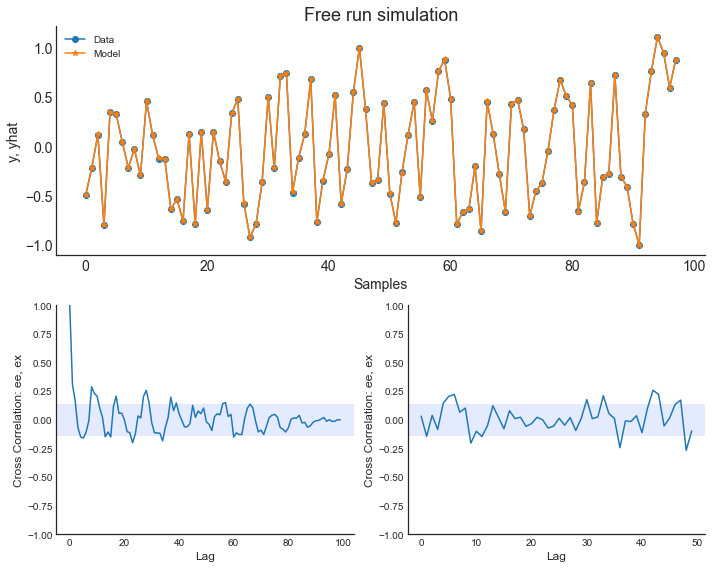

In [8]:
ee, ex, extras, lam = model.residuals(x_valid, y_valid, yhat)
model.plot_result(y_valid, yhat, ee, ex)


## Setting the *n_terms* parameter

In the example above we let the number of terms to compose the final model to be defined as the minimum value of the information criteria. Once you ran the algorithm and choose the best number of parameters, you can turn *order_selection* to *False* and set the *n_terms* value (3 in this example). Here we have a small dataset, but in bigger data this can be critical because running information criteria algorithm is more computational expensive. Since we already know the best number of regressor, we set *n_terms* and we get the same result.

However, this is not only critical because computational eficiency. In many situation, the minimum value of the information criteria can lead to overfiting. In some cases, the diference between choosing a model with 30 regressors or 10 is minimal, so you can take the model with 10 terms without loosing accuracy.

In the following we use *info_values* to plot the information criteria values. As you can see, the minimum value relies where $xaxis = 5$ 

Text(0, 0.5, 'Information Criteria')

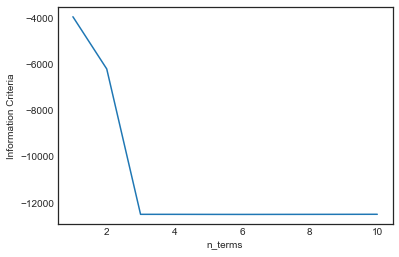

In [9]:
xaxis = np.arange(1, model.n_info_values + 1)
plt.plot(xaxis, model.info_values)
plt.xlabel('n_terms')
plt.ylabel('Information Criteria')

```{note}
 Here we are creating random samples with white noise and letting the algorithm choose
 the number of terms based on the minimum value of information criteria. 
 This is not the best approach in System Identification, but serves as a simple example. 
 The information criteria must be used as an __auxiliary tool__ to select *n_terms*. 
 Plot the information values to help you on that!

 If you run the example above several times you might find some cases where the
 algorithm choose only the first two regressors, or four (depending on the information
 criteria method selected). This is because the minimum value of information criteria
 depends on residual variance (affected by noise) and have some limitations in nonlinear
 scenarios. However, if you check the ERR values (robust to noise) you will see that the
 ERR is ordering the regressors in the correct way!

 We have some examples on *information_criteria* notebook!
```

```{note}
This documentation and the examples below are written with MyST Markdown, a form
of markdown that works with Sphinx. For more information about MyST markdown, and
to use MyST markdown with your Sphinx website,
see [the MyST-parser documentation](https://myst-parser.readthedocs.io/)
```

The *n_info_values* limits the number of regressors to apply the information criteria. We choose $n_y = n_x = \ell = 2$, so the candidate regressor is a list of 15 regressors. We can set *n_info_values = 15* and see the information values for all regressors. This option can save some amount of computational resources when dealing with multiples inputs and large datasets.

Text(0, 0.5, 'Information Criteria')

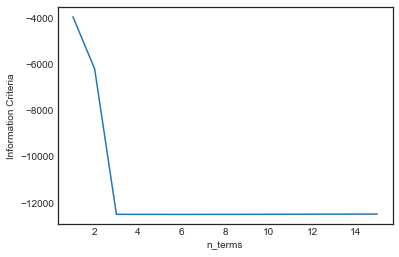

In [10]:
model = PolynomialNarmax(non_degree=2,
                         order_selection=True,
                         n_info_values=15,
                         extended_least_squares=False,
                         ylag=2, xlag=2,
                         info_criteria='aic',
                         estimator='least_squares',
                         )

model.fit(x_train, y_train)

xaxis = np.arange(1, model.n_info_values + 1)
plt.plot(xaxis, model.info_values)
plt.xlabel('n_terms')
plt.ylabel('Information Criteria')

Now running without executing information criteria methods (setting the *n_terms*) because we already know the optimal number of regressors

In [11]:
model = PolynomialNarmax(non_degree=2,
                         # order_selection=True,
                         n_terms = 3,
                         # n_info_values=15,
                         extended_least_squares=False,
                         ylag=2, xlag=2,
                         info_criteria='aic',
                         estimator='least_squares',
                         )

model.fit(x_train, y_train)
yhat = model.predict(x_valid, y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
print('rrse: ', rrse)

results = pd.DataFrame(model.results(err_precision=8,
                                     dtype='dec'),
                       columns=['Regressors', 'Parameters', 'ERR'])

print('\n', results)

rrse:  0.0018136024659265537

       Regressors Parameters         ERR
0        x1(k-2)     0.9000  0.95739001
1         y(k-1)     0.2000  0.03917632
2  x1(k-1)y(k-1)     0.0999  0.00343057


## Extra information

You can acess some extra information like the list of all candidate regressors

In [12]:
# for now the list is returned as a codification. Here, $0$ is the constant term, $[1001]=y{k-1}, [100n]=y_{k-n}, [200n] = x1_{k-n}, [300n]=x2_{k-n}$ and so on
model.regressor_code  # list of all possible regressors given non_degree, n_y and n_x values

array([[   0,    0],
       [1001,    0],
       [1002,    0],
       [2001,    0],
       [2002,    0],
       [1001, 1001],
       [1002, 1001],
       [2001, 1001],
       [2002, 1001],
       [1002, 1002],
       [2001, 1002],
       [2002, 1002],
       [2001, 2001],
       [2002, 2001],
       [2002, 2002]])

In [13]:
print(model.err, '\n\n')  # err values for the selected terms
print(model.theta)  # estimated parameters for the final model structure

[0.95739001 0.03917632 0.00343057 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ] 


[[0.89995854]
 [0.20004441]
 [0.09991068]]
